# Soil Fertility Prediction using Logistic Regression

This notebook demonstrates the process of building and evaluating a Logistic Regression model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe).

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
data_path = '../Datasets/dataset_1.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (880, 6)


,N,P,K,EC,Fe,Output
0,138,8.6,560,0.62,0.31,0
1,213,7.5,338,0.75,0.86,0
2,163,9.6,718,0.51,0.86,0
3,157,6.8,475,0.58,0.54,0
4,270,9.9,444,0.40,0.76,1
5,220,8.6,444,0.65,0.66,0
6,220,7.2,222,0.43,0.69,0
7,207,7.0,401,0.59,0.68,0
8,289,8.6,560,0.44,0.66,1
9,138,8.1,739,0.33,0.41,0


In [3]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
N         0
P         0
K         0
EC        0
Fe        0
Output    0
dtype: int64


In [5]:
# Statistical summary of the dataset
data.describe()

,N,P,K,EC,Fe,Output
count,880.00000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,246.73750,14.562159,499.978409,0.543659,4.140523,0.588636
std,77.38886,21.967755,124.222838,0.141597,3.110011,0.575462
min,6.00000,2.900000,11.000000,0.100000,0.210000,0.000000
25%,201.00000,6.800000,412.000000,0.430000,2.050000,0.000000
50%,257.00000,8.100000,475.000000,0.545000,3.565000,1.000000
75%,307.00000,10.550000,581.000000,0.640000,6.320000,1.000000
max,383.00000,125.000000,887.000000,0.950000,44.000000,2.000000


Class distribution:
Output
1    440
0    401
2     39
Name: count, dtype: int64


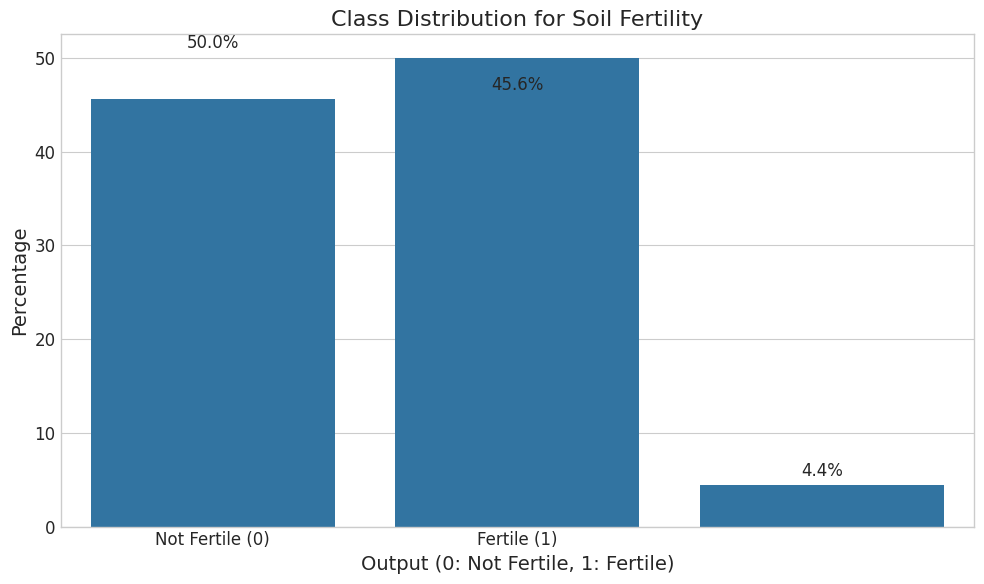

In [6]:
# Check class distribution
class_counts = data['Output'].value_counts()
print("Class distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_percentages = data['Output'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution for Soil Fertility', fontsize=16)
plt.xlabel('Output (0: Not Fertile, 1: Fertile)', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks([0, 1], ['Not Fertile (0)', 'Fertile (1)'])

# Add percentage labels on top of bars
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

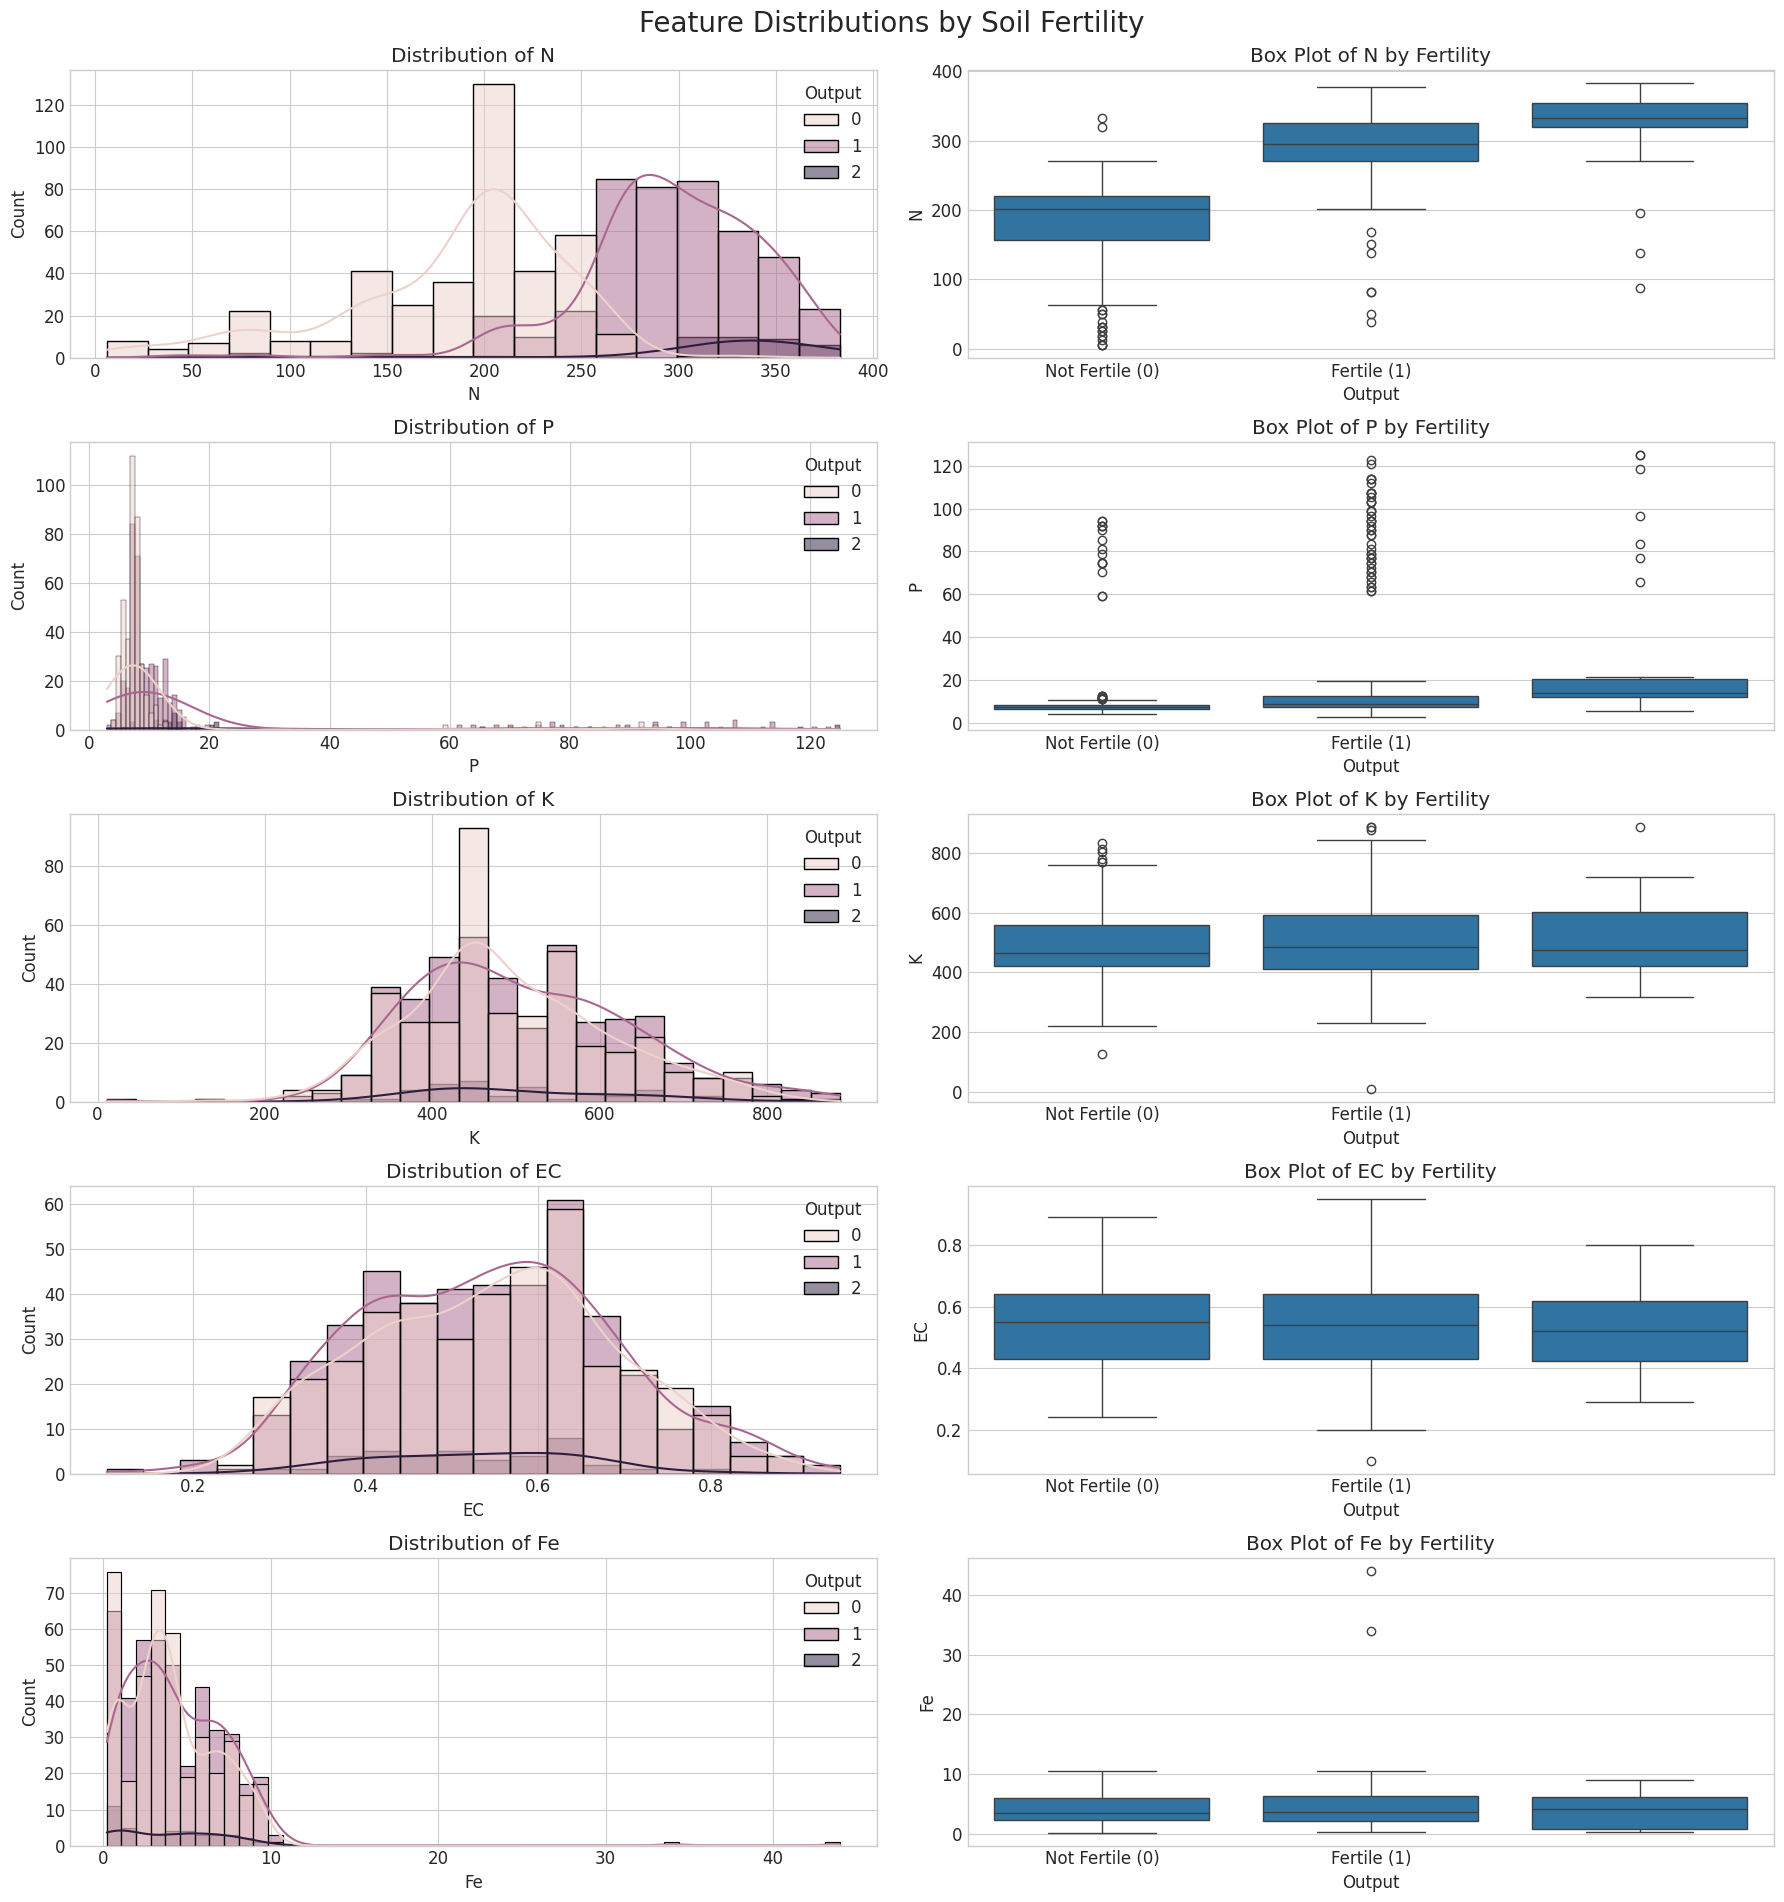

In [7]:
# Visualize the distribution of features
features = data.columns[:-1]  # All columns except the target 'Output'

fig, axes = plt.subplots(len(features), 2, figsize=(18, 20))
fig.suptitle('Feature Distributions by Soil Fertility', fontsize=20, y=0.95)

for i, feature in enumerate(features):
    # Histogram
    sns.histplot(data=data, x=feature, hue='Output', kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(data=data, x='Output', y=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature} by Fertility')
    
    # Fix for UserWarning: set fixed tick positions before setting tick labels
    axes[i, 1].set_xticks([0, 1])
    axes[i, 1].set_xticklabels(['Not Fertile (0)', 'Fertile (1)'])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

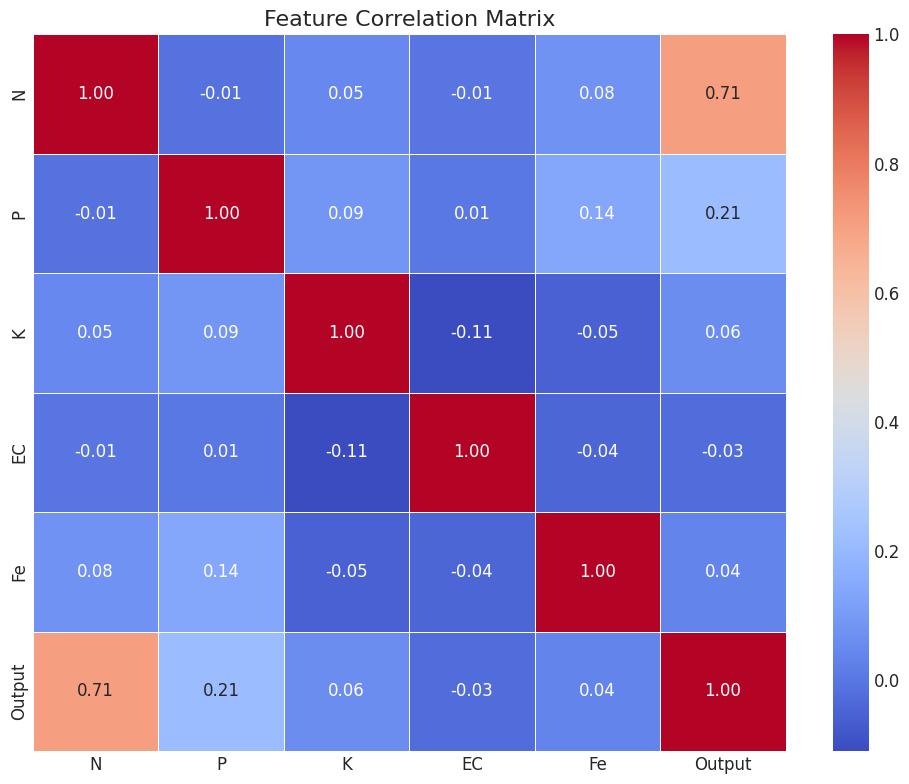

In [8]:
# Correlation matrix and heatmap
correlation = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 2000x1600 with 0 Axes>

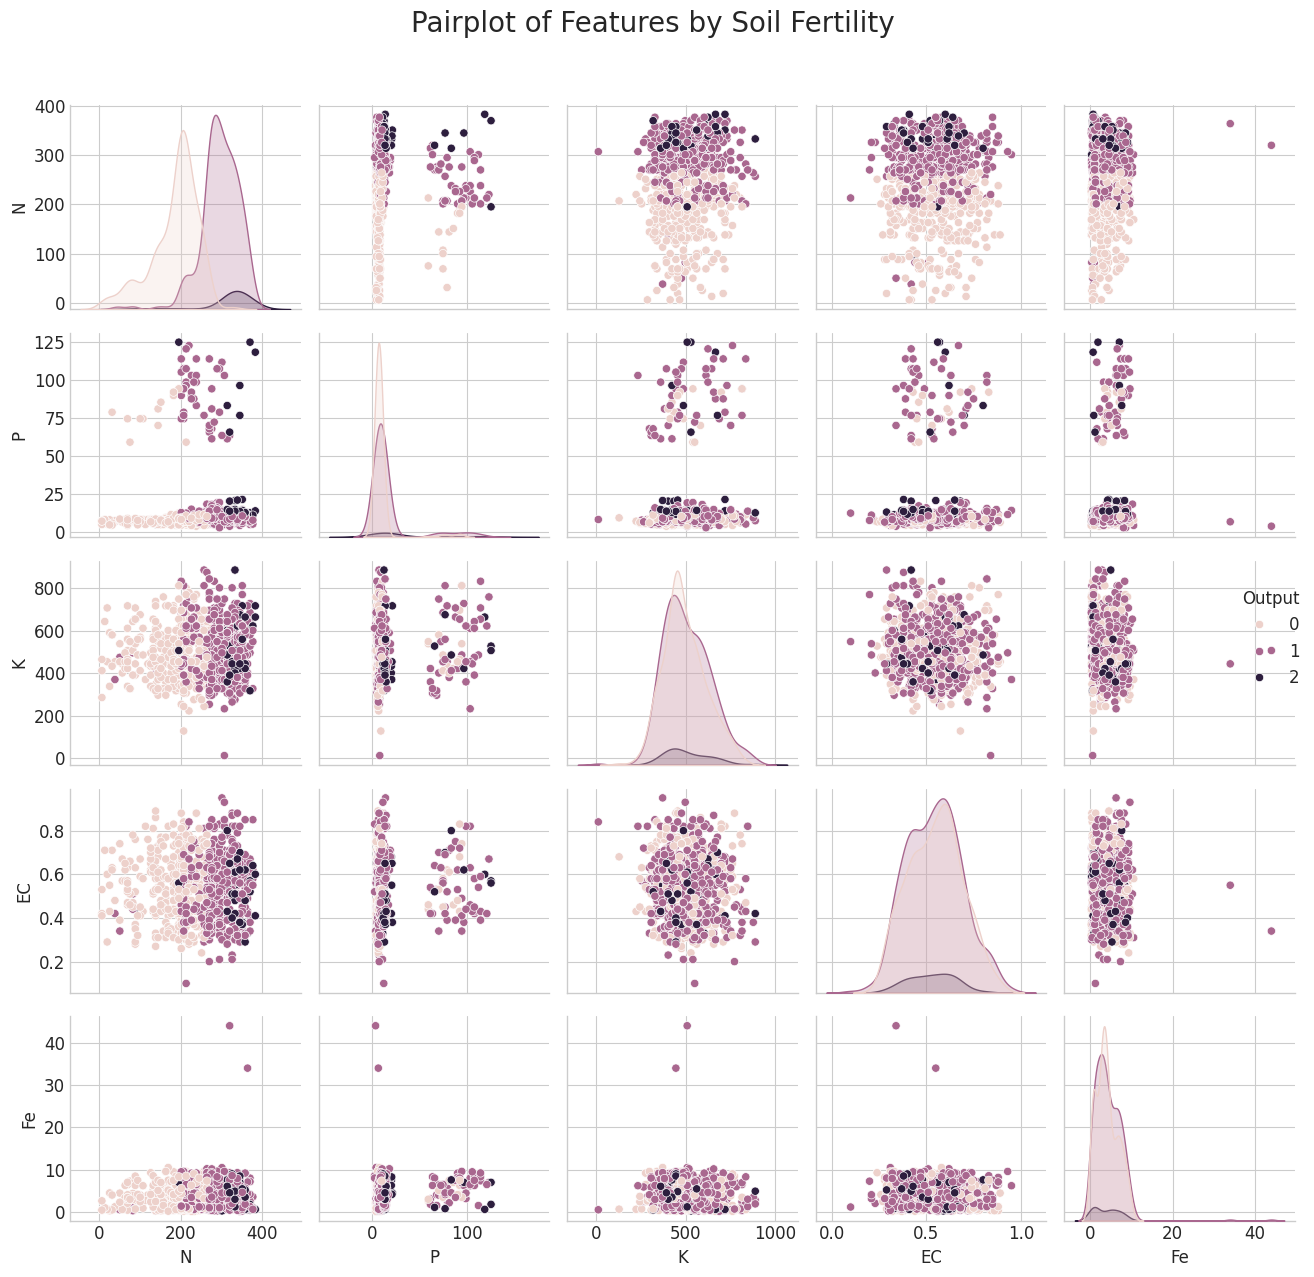

In [9]:
# Pairplot to visualize relationships between features
plt.figure(figsize=(20, 16))
sns.pairplot(data, hue='Output', diag_kind='kde')
plt.suptitle('Pairplot of Features by Soil Fertility', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [10]:
# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (704, 5)
Testing set shape: (176, 5)

Class distribution in training set:
Output
1    50.000000
0    45.596591
2     4.403409
Name: proportion, dtype: float64

Class distribution in testing set:
Output
1    50.000000
0    45.454545
2     4.545455
Name: proportion, dtype: float64


## 5. Model Training with Hyperparameter Tuning

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

# Define the hyperparameter search space
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Define valid solver-penalty combinations
compatible_params = [
    {"classifier__penalty": ["l2"], "classifier__solver": ["lbfgs", "newton-cg", "sag", "saga"], "classifier__C": param_grid["classifier__C"]},
    {"classifier__penalty": ["l1"], "classifier__solver": ["liblinear", "saga"], "classifier__C": param_grid["classifier__C"]},
    {"classifier__penalty": ["elasticnet"], "classifier__solver": ["saga"], "classifier__C": param_grid["classifier__C"], "classifier__l1_ratio": [0.5, 1]},
    {"classifier__penalty": [None], "classifier__solver": ["newton-cg", "lbfgs", "sag", "saga"]}  # No C for None penalty
]

# Run grid search
print("Performing grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, compatible_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 52 candidates, totalling 260 fits

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score: 0.8864


In [14]:
# Plot Grid Search Results
cv_results = grid_search.cv_results_
params = cv_results['params']
mean_scores = cv_results['mean_test_score']

# Group by penalty and solver
param_groups = {}
for i, param in enumerate(params):
    key = f"{param['classifier__penalty']}_{param['classifier__solver']}"
    if key not in param_groups:
        param_groups[key] = {'C': [], 'score': []}
    param_groups[key]['C'].append(param['classifier__C'])
    param_groups[key]['score'].append(mean_scores[i])

# Plot
plt.figure(figsize=(15, 10))
for key, values in param_groups.items():
    penalty, solver = key.split('_')
    if len(values['C']) > 0:  # Only plot if we have data points
        plt.plot(values['C'], values['score'], 'o-', label=f"penalty={penalty}, solver={solver}")

plt.xscale('log')
plt.xlabel('Regularization Parameter (C)', fontsize=14)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=14)
plt.title('Grid Search Results for Logistic Regression', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'classifier__C'

## 6. Model Evaluation

In [ ]:
# Make predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Training accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print(f"Training accuracy: {train_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=['Not Fertile (0)', 'Fertile (1)'],
    yticklabels=['Not Fertile (0)', 'Fertile (1)']
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations with percentages
total = np.sum(conf_matrix)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix[i, j] / total * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

In [ ]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance
# For logistic regression, we can use the coefficients
if hasattr(best_model[-1], 'coef_'):
    coefficients = best_model[-1].coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients,
        'Absolute Importance': np.abs(coefficients)
    }).sort_values(by='Absolute Importance', ascending=False)
    
    print("Feature Importance:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    
    # Absolute importance
    plt.subplot(1, 2, 1)
    sns.barplot(x='Absolute Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Absolute)', fontsize=14)
    plt.tight_layout()
    
    # Directional importance
    plt.subplot(1, 2, 2)
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.sort_values('Coefficient'))
    plt.title('Feature Importance (Directional)', fontsize=14)
    plt.axvline(x=0, color='gray', linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Learning curve to assess overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Save the Trained Model

In [ ]:
# Define the directory for saving models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'logistic_regression_model.pkl')
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

## 8. Model Application - Prediction Function

In [ ]:
def predict_soil_fertility(model, n, p, k, ec, fe):
    """
    Predict soil fertility using the trained model.
    
    Parameters:
    - model: Trained Logistic Regression model
    - n: Nitrogen level
    - p: Phosphorus level
    - k: Potassium level
    - ec: Electrical Conductivity
    - fe: Iron level
    
    Returns:
    - prediction: 0 (not fertile) or 1 (fertile)
    - probability: Probability of being fertile
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'EC': [ec],
        'Fe': [fe]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0, 1]
    
    return prediction, probability

In [ ]:
# Example usage - test with some sample data
# Sample 1 (expected to be not fertile)
sample1 = {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 0.4}
# Sample 2 (expected to be fertile)
sample2 = {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 0.8}

# Make predictions
pred1, prob1 = predict_soil_fertility(best_model, **sample1)
pred2, prob2 = predict_soil_fertility(best_model, **sample2)

# Print results
print("Sample 1:")
print(f"Input: {sample1}")
print(f"Prediction: {'Fertile' if pred1 == 1 else 'Not Fertile'}")
print(f"Probability of being fertile: {prob1:.4f}")

print("\nSample 2:")
print(f"Input: {sample2}")
print(f"Prediction: {'Fertile' if pred2 == 1 else 'Not Fertile'}")
print(f"Probability of being fertile: {prob2:.4f}")

## 9. Interactive Prediction

In [ ]:
from ipywidgets import interact, FloatSlider, Label, VBox, HBox, Output
import ipywidgets as widgets

# Get the ranges for each feature from the dataset
feature_ranges = {
    'N': {'min': data['N'].min(), 'max': data['N'].max()},
    'P': {'min': data['P'].min(), 'max': data['P'].max()},
    'K': {'min': data['K'].min(), 'max': data['K'].max()},
    'EC': {'min': data['EC'].min(), 'max': data['EC'].max()},
    'Fe': {'min': data['Fe'].min(), 'max': data['Fe'].max()}
}

# Create sliders
n_slider = FloatSlider(
    min=feature_ranges['N']['min'],
    max=feature_ranges['N']['max'],
    step=1,
    value=(feature_ranges['N']['min'] + feature_ranges['N']['max']) / 2,
    description='Nitrogen:'
)

p_slider = FloatSlider(
    min=feature_ranges['P']['min'],
    max=feature_ranges['P']['max'],
    step=0.1,
    value=(feature_ranges['P']['min'] + feature_ranges['P']['max']) / 2,
    description='Phosphorus:'
)

k_slider = FloatSlider(
    min=feature_ranges['K']['min'],
    max=feature_ranges['K']['max'],
    step=1,
    value=(feature_ranges['K']['min'] + feature_ranges['K']['max']) / 2,
    description='Potassium:'
)

ec_slider = FloatSlider(
    min=feature_ranges['EC']['min'],
    max=feature_ranges['EC']['max'],
    step=0.01,
    value=(feature_ranges['EC']['min'] + feature_ranges['EC']['max']) / 2,
    description='EC:'
)

fe_slider = FloatSlider(
    min=feature_ranges['Fe']['min'],
    max=feature_ranges['Fe']['max'],
    step=0.01,
    value=(feature_ranges['Fe']['min'] + feature_ranges['Fe']['max']) / 2,
    description='Iron:'
)

# Output widget
output = Output()

# Update function
def update_prediction(N, P, K, EC, Fe):
    prediction, probability = predict_soil_fertility(best_model, N, P, K, EC, Fe)
    result = 'Fertile' if prediction == 1 else 'Not Fertile'
    
    with output:
        output.clear_output()
        print(f"Prediction: {result}")
        print(f"Probability of being fertile: {probability:.4f}")
        
        # Visualization
        color = 'green' if prediction == 1 else 'red'
        plt.figure(figsize=(8, 2))
        plt.barh(['Fertility'], [probability], color=color)
        plt.xlim(0, 1)
        plt.title(f"Soil Fertility Prediction: {result}")
        plt.xlabel('Probability of being fertile')
        plt.tight_layout()
        plt.show()

# Create interactive widget
interactive_prediction = interact(
    update_prediction,
    N=n_slider,
    P=p_slider,
    K=k_slider,
    EC=ec_slider,
    Fe=fe_slider
)

# Display the output
display(output)

## 10. Conclusions and Next Steps

### Summary
In this notebook, we have:
1. Loaded and explored the soil fertility dataset
2. Performed exploratory data analysis to understand feature distributions and relationships
3. Preprocessed the data by scaling features and splitting into training/testing sets
4. Trained a Logistic Regression model with hyperparameter tuning
5. Evaluated model performance using various metrics and visualizations
6. Saved the trained model for future use
7. Created an interactive prediction interface

### Key Insights
- The model's performance metrics (accuracy, precision, recall) indicate how well it can predict soil fertility
- Feature importance analysis reveals which soil parameters are most influential in determining fertility
- The interactive prediction tool provides a user-friendly way to make predictions with new data

### Next Steps
1. Expand the analysis with additional models (as mentioned in MODELS.md): KNN, SVM, and Random Forest Classifier
2. Compare the performance of all models to select the best one for implementation
3. Integrate the model with IoT sensors for real-time soil parameter readings
4. Develop the .NET MAUI application interface for user-friendly access to predictions
5. Implement model monitoring to track performance over time and with new data

This model serves as the first step in creating a comprehensive soil fertility analysis system for the SDP_Agri_Swastha project.